Завдання

За допомогою багатошарових нейронних мереж прямого поширення розв’язати
задачі регресії (перша задача) та класифікації (друга задача). Використати
навчання з учителем. Підібрати кількість епох навчання в залежності від
специфіки задачі. В усіх варіантах:
1) обчислити тривалість навчання, вказати точність мережі, та побудувати
графік функції похибки (втрат) мережі на навчальній вибірці та множині
валідації. Використати 20% навчальної вибірки для валідації;
2) порівняти якість роботи алгоритму навчання для різних оптимізаторів та
різних функцій активації нейронів;
3) спробувати розв’язати задачу на нейромережах з різною кількістю
прихованих шарів;
4) для наборів даних, у яких відсутнє розбиття на навчальну та тестову вибірку,
занести 25% випадковим чином вибраних записів із набору даних у тестову
вибірку, решту — у навчальну вибірку.
Умови завдань
Варіант № 1

1. Провести навчання нейромережі, яка призначена для реалізації додавання за
модулем 2 у випадку 10 бінарних входів. Використати пакетне навчання із
пакетом (batch_size) 128.
2. Навчити нейромережу розпізнавати цифри із набору даних “Optical
recognition of handwritten digits dataset”, який можна завантажити з
sklearn.datasets (функція load_digits()).

In [2]:
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

In [3]:
# -------------------------------
# Helper: Define a general feed-forward network
# -------------------------------
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        """
        Constructs a feed-forward network.
        :param input_size: number of input neurons.
        :param hidden_sizes: list with number of neurons in each hidden layer.
        :param output_size: number of output neurons.
        :param activation_fn: activation function class (e.g. nn.ReLU).
        """
        super(FeedForwardNN, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(activation_fn())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [4]:
# -------------------------------
# Training and evaluation routines
# -------------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, task="binary"):
    """
    Train the model and record loss and accuracy.
    :param model: the neural network.
    :param criterion: loss function.
    :param optimizer: optimizer.
    :param train_loader: DataLoader for training set.
    :param val_loader: DataLoader for validation set.
    :param device: "cuda" or "cpu".
    :param num_epochs: number of training epochs.
    :param task: "binary" (for BCEWithLogitsLoss) or "multiclass" (for CrossEntropyLoss).
    :return: lists of training and validation losses and training duration.
    """
    model.to(device)
    train_losses = []
    val_losses = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            if task == "binary":
                # For binary: apply sigmoid and threshold at 0.5
                preds = (torch.sigmoid(outputs) > 0.5).float()
            else:
                # For multiclass: take argmax along the class dimension.
                preds = torch.argmax(outputs, dim=1)
                labels = labels.long().squeeze() if labels.dim() > 1 else labels.long()
                
            correct_train += (preds == labels).sum().item()
            total_train += inputs.size(0)
            
        epoch_loss = running_loss / total_train
        train_losses.append(epoch_loss)
        train_acc = correct_train / total_train
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                if task == "binary":
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                else:
                    preds = torch.argmax(outputs, dim=1)
                    labels = labels.long().squeeze() if labels.dim() > 1 else labels.long()
                correct_val += (preds == labels).sum().item()
                total_val += inputs.size(0)
        val_loss = running_val_loss / total_val
        val_losses.append(val_loss)
        val_acc = correct_val / total_val
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
    duration = time.time() - start_time
    print(f"Training duration: {duration:.2f} seconds\n")
    return train_losses, val_losses, duration

def evaluate_model(model, test_loader, device, task="binary"):
    """
    Evaluate the trained model on the test set.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            if task == "binary":
                preds = (torch.sigmoid(outputs) > 0.5).float()
            else:
                preds = torch.argmax(outputs, dim=1)
                labels = labels.long().squeeze() if labels.dim() > 1 else labels.long()
            correct += (preds == labels).sum().item()
            total += inputs.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}\n")
    return acc

def plot_loss(train_losses, val_losses, title="Loss Curve"):
    """
    Plot training and validation loss curves.
    """
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [5]:
# -------------------------------
# Task 1: Addition modulo 2 (10 binary inputs)
# -------------------------------
def generate_mod2_data(num_inputs=10):
    """
    Generate all 2^(num_inputs) binary vectors and compute the sum modulo 2.
    (This function implements a parity function over the 10 inputs.)
    """
    X = np.array(list(itertools.product([0, 1], repeat=num_inputs)), dtype=np.float32)
    y = np.mod(np.sum(X, axis=1), 2).reshape(-1, 1).astype(np.float32)
    return X, y

In [6]:
def main_mod2(activation_fn, optimizer_name, hidden_layers, num_epochs=50, batch_size=128):
    print("=== Running Addition Modulo 2 Task ===")
    # Generate data
    X, y = generate_mod2_data(num_inputs=10)
    X = torch.tensor(X)
    y = torch.tensor(y)
    
    # Create dataset and split into training and test sets (25% for test)
    dataset = TensorDataset(X, y)
    test_size = int(0.25 * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Further split training set into training (80%) and validation (20%)
    val_size = int(0.2 * len(train_dataset))
    train_size_final = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Build the network (output_size = 1 for binary decision)
    model = FeedForwardNN(input_size=10, hidden_sizes=hidden_layers, output_size=1, activation_fn=activation_fn)
    
    # Loss: Binary Cross Entropy with Logits (works directly with raw outputs)
    criterion = nn.BCEWithLogitsLoss()
    
    # Choose optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.1)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    
    print(f"Parameters: Optimizer={optimizer_name}, Activation={activation_fn.__name__}, Hidden Layers={hidden_layers}")
    train_losses, val_losses, duration = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=num_epochs, task="binary")
    test_acc = evaluate_model(model, test_loader, device, task="binary")
    plot_loss(train_losses, val_losses, title=f"Mod2 Addition Loss ({optimizer_name}, {activation_fn.__name__}, {hidden_layers})")
    return model, test_acc, duration

In [7]:
# -------------------------------
# Task 2: Digit Classification (sklearn's load_digits)
# -------------------------------
def main_digits(activation_fn, optimizer_name, hidden_layers, num_epochs=50, batch_size=128):
    print("=== Running Digit Classification Task ===")
    # Load data
    digits = load_digits()
    X = digits.data.astype(np.float32)  # shape: (n_samples, 64)
    y = digits.target.astype(np.int64)
    
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    X = torch.tensor(X)
    y = torch.tensor(y)
    
    dataset = TensorDataset(X, y)
    test_size = int(0.25 * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Split training into training (80%) and validation (20%)
    val_size = int(0.2 * len(train_dataset))
    train_size_final = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Build the network: input_size = 64, output_size = 10 (for 10 digit classes)
    model = FeedForwardNN(input_size=64, hidden_sizes=hidden_layers, output_size=10, activation_fn=activation_fn)
    
    # Loss: CrossEntropyLoss (the model outputs raw scores for each class)
    criterion = nn.CrossEntropyLoss()
    
    # Choose optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.1)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    
    print(f"Parameters: Optimizer={optimizer_name}, Activation={activation_fn.__name__}, Hidden Layers={hidden_layers}")
    train_losses, val_losses, duration = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=num_epochs, task="multiclass")
    test_acc = evaluate_model(model, test_loader, device, task="multiclass")
    plot_loss(train_losses, val_losses, title=f"Digit Classification Loss ({optimizer_name}, {activation_fn.__name__}, {hidden_layers})")
    return model, test_acc, duration

In [10]:
activations = [nn.ReLU, nn.Tanh]  # You can also add nn.Sigmoid
optimizers_list = ["SGD", "Adam"]
hidden_layer_configs = {
    "1_hidden": [32],
    "2_hidden": [64, 32],
    "3_hidden": [128, 64, 32]  # Uncomment to test three hidden layers
}

num_epochs = 50
batch_size = 128

Running mod2 with ReLU, SGD, configuration: 1_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=SGD, Activation=ReLU, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 0.6961 | Train Acc: 0.4992 | Val Loss: 0.6915 | Val Acc: 0.5163
Epoch 2/50 | Train Loss: 0.6953 | Train Acc: 0.4846 | Val Loss: 0.6918 | Val Acc: 0.5229
Epoch 3/50 | Train Loss: 0.6948 | Train Acc: 0.5024 | Val Loss: 0.6920 | Val Acc: 0.5359
Epoch 4/50 | Train Loss: 0.6949 | Train Acc: 0.4976 | Val Loss: 0.6920 | Val Acc: 0.5359
Epoch 5/50 | Train Loss: 0.6947 | Train Acc: 0.5057 | Val Loss: 0.6917 | Val Acc: 0.5163
Epoch 6/50 | Train Loss: 0.6944 | Train Acc: 0.5073 | Val Loss: 0.6917 | Val Acc: 0.5163
Epoch 7/50 | Train Loss: 0.6944 | Train Acc: 0.5057 | Val Loss: 0.6917 | Val Acc: 0.5229
Epoch 8/50 | Train Loss: 0.6943 | Train Acc: 0.5057 | Val Loss: 0.6919 | Val Acc: 0.5098
Epoch 9/50 | Train Loss: 0.6942 | Train Acc: 0.5041 | Val Loss: 0.6921 | Val Acc: 0.5163
Epoch 10/50 | Train Loss: 0.6941 | Train Acc

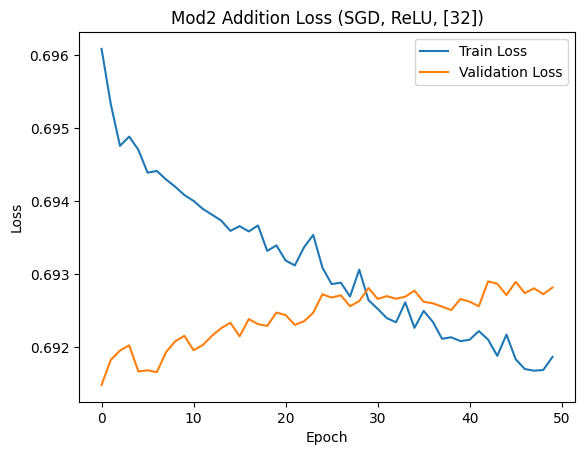

Result: Test Accuracy: 0.4766 | Training Duration: 0.21 sec

Running mod2 with ReLU, SGD, configuration: 2_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=SGD, Activation=ReLU, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 0.6964 | Train Acc: 0.4943 | Val Loss: 0.6971 | Val Acc: 0.4641
Epoch 2/50 | Train Loss: 0.6957 | Train Acc: 0.4911 | Val Loss: 0.6957 | Val Acc: 0.4575
Epoch 3/50 | Train Loss: 0.6949 | Train Acc: 0.4911 | Val Loss: 0.6946 | Val Acc: 0.4510
Epoch 4/50 | Train Loss: 0.6944 | Train Acc: 0.4829 | Val Loss: 0.6940 | Val Acc: 0.4771
Epoch 5/50 | Train Loss: 0.6942 | Train Acc: 0.4878 | Val Loss: 0.6933 | Val Acc: 0.5098
Epoch 6/50 | Train Loss: 0.6939 | Train Acc: 0.4943 | Val Loss: 0.6928 | Val Acc: 0.5359
Epoch 7/50 | Train Loss: 0.6939 | Train Acc: 0.4894 | Val Loss: 0.6926 | Val Acc: 0.5294
Epoch 8/50 | Train Loss: 0.6938 | Train Acc: 0.4959 | Val Loss: 0.6923 | Val Acc: 0.5163
Epoch 9/50 | Train Loss: 0.6936 | Train Acc: 0.4862 | Val Loss: 0.69

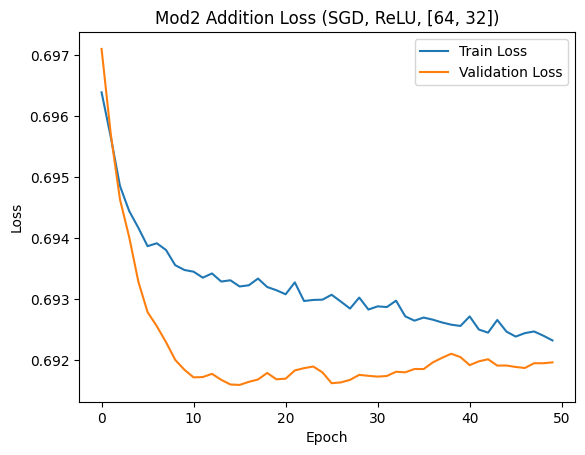

Result: Test Accuracy: 0.4180 | Training Duration: 0.24 sec

Running mod2 with ReLU, SGD, configuration: 3_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=SGD, Activation=ReLU, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 0.6937 | Train Acc: 0.5220 | Val Loss: 0.7059 | Val Acc: 0.4510
Epoch 2/50 | Train Loss: 0.6931 | Train Acc: 0.5220 | Val Loss: 0.7045 | Val Acc: 0.4510
Epoch 3/50 | Train Loss: 0.6927 | Train Acc: 0.5220 | Val Loss: 0.7034 | Val Acc: 0.4510
Epoch 4/50 | Train Loss: 0.6925 | Train Acc: 0.5220 | Val Loss: 0.7027 | Val Acc: 0.4510
Epoch 5/50 | Train Loss: 0.6926 | Train Acc: 0.5220 | Val Loss: 0.7020 | Val Acc: 0.4510
Epoch 6/50 | Train Loss: 0.6924 | Train Acc: 0.5220 | Val Loss: 0.7014 | Val Acc: 0.4510
Epoch 7/50 | Train Loss: 0.6923 | Train Acc: 0.5220 | Val Loss: 0.7010 | Val Acc: 0.4510
Epoch 8/50 | Train Loss: 0.6922 | Train Acc: 0.5220 | Val Loss: 0.7008 | Val Acc: 0.4510
Epoch 9/50 | Train Loss: 0.6922 | Train Acc: 0.5220 | Val Loss:

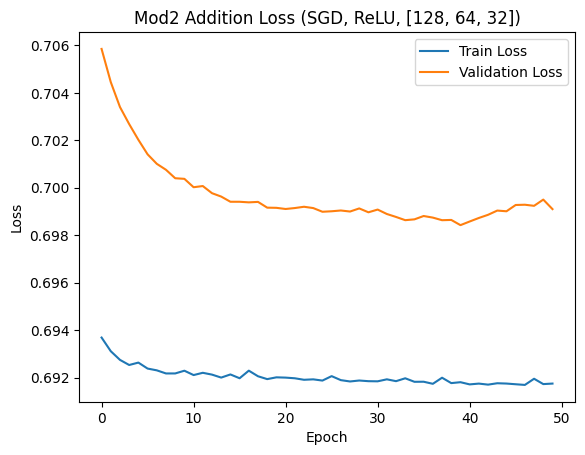

Result: Test Accuracy: 0.4766 | Training Duration: 0.30 sec

Running mod2 with ReLU, Adam, configuration: 1_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=Adam, Activation=ReLU, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 0.6992 | Train Acc: 0.4846 | Val Loss: 0.7054 | Val Acc: 0.4771
Epoch 2/50 | Train Loss: 0.6952 | Train Acc: 0.5285 | Val Loss: 0.6993 | Val Acc: 0.4706
Epoch 3/50 | Train Loss: 0.6902 | Train Acc: 0.5301 | Val Loss: 0.6978 | Val Acc: 0.4641
Epoch 4/50 | Train Loss: 0.6905 | Train Acc: 0.5057 | Val Loss: 0.6977 | Val Acc: 0.4967
Epoch 5/50 | Train Loss: 0.6896 | Train Acc: 0.5220 | Val Loss: 0.6982 | Val Acc: 0.5098
Epoch 6/50 | Train Loss: 0.6878 | Train Acc: 0.5463 | Val Loss: 0.6995 | Val Acc: 0.4314
Epoch 7/50 | Train Loss: 0.6876 | Train Acc: 0.5561 | Val Loss: 0.6988 | Val Acc: 0.4902
Epoch 8/50 | Train Loss: 0.6856 | Train Acc: 0.5626 | Val Loss: 0.6999 | Val Acc: 0.4771
Epoch 9/50 | Train Loss: 0.6837 | Train Acc: 0.5789 | Val Loss: 0.6994

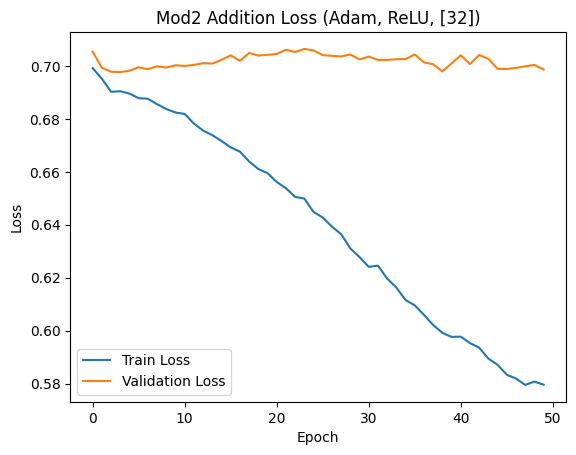

Result: Test Accuracy: 0.5273 | Training Duration: 0.28 sec

Running mod2 with ReLU, Adam, configuration: 2_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=Adam, Activation=ReLU, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 0.6995 | Train Acc: 0.4732 | Val Loss: 0.6947 | Val Acc: 0.4641
Epoch 2/50 | Train Loss: 0.6931 | Train Acc: 0.4715 | Val Loss: 0.6951 | Val Acc: 0.4641
Epoch 3/50 | Train Loss: 0.6922 | Train Acc: 0.5187 | Val Loss: 0.6961 | Val Acc: 0.4248
Epoch 4/50 | Train Loss: 0.6912 | Train Acc: 0.5431 | Val Loss: 0.6983 | Val Acc: 0.4314
Epoch 5/50 | Train Loss: 0.6906 | Train Acc: 0.5333 | Val Loss: 0.7003 | Val Acc: 0.4314
Epoch 6/50 | Train Loss: 0.6887 | Train Acc: 0.5480 | Val Loss: 0.7025 | Val Acc: 0.4444
Epoch 7/50 | Train Loss: 0.6866 | Train Acc: 0.5610 | Val Loss: 0.7066 | Val Acc: 0.4379
Epoch 8/50 | Train Loss: 0.6841 | Train Acc: 0.5496 | Val Loss: 0.7104 | Val Acc: 0.4444
Epoch 9/50 | Train Loss: 0.6799 | Train Acc: 0.5805 | Val Loss: 0.

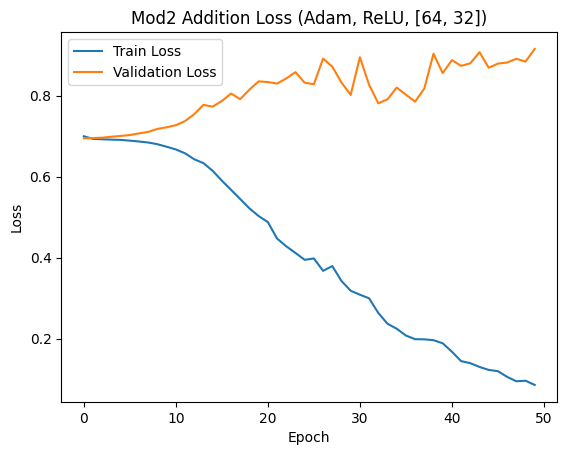

Result: Test Accuracy: 0.7578 | Training Duration: 0.32 sec

Running mod2 with ReLU, Adam, configuration: 3_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=Adam, Activation=ReLU, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 0.6930 | Train Acc: 0.5138 | Val Loss: 0.7140 | Val Acc: 0.4967
Epoch 2/50 | Train Loss: 0.6918 | Train Acc: 0.5106 | Val Loss: 0.6997 | Val Acc: 0.3922
Epoch 3/50 | Train Loss: 0.6914 | Train Acc: 0.5350 | Val Loss: 0.7073 | Val Acc: 0.4575
Epoch 4/50 | Train Loss: 0.6874 | Train Acc: 0.5366 | Val Loss: 0.7232 | Val Acc: 0.3660
Epoch 5/50 | Train Loss: 0.6846 | Train Acc: 0.5528 | Val Loss: 0.7405 | Val Acc: 0.3660
Epoch 6/50 | Train Loss: 0.6850 | Train Acc: 0.5480 | Val Loss: 0.7325 | Val Acc: 0.4183
Epoch 7/50 | Train Loss: 0.6793 | Train Acc: 0.5870 | Val Loss: 0.7499 | Val Acc: 0.3856
Epoch 8/50 | Train Loss: 0.6788 | Train Acc: 0.5561 | Val Loss: 0.7346 | Val Acc: 0.4314
Epoch 9/50 | Train Loss: 0.6697 | Train Acc: 0.6163 | Val Los

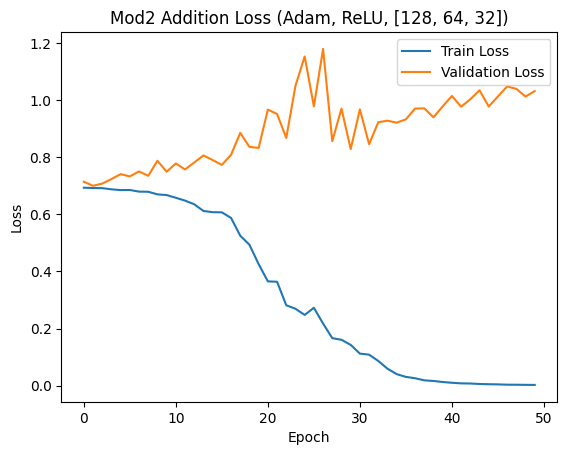

Result: Test Accuracy: 0.8359 | Training Duration: 0.34 sec

Running mod2 with Tanh, SGD, configuration: 1_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=SGD, Activation=Tanh, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 0.7060 | Train Acc: 0.4683 | Val Loss: 0.6927 | Val Acc: 0.5294
Epoch 2/50 | Train Loss: 0.6978 | Train Acc: 0.4846 | Val Loss: 0.6917 | Val Acc: 0.5359
Epoch 3/50 | Train Loss: 0.6958 | Train Acc: 0.4959 | Val Loss: 0.6921 | Val Acc: 0.5033
Epoch 4/50 | Train Loss: 0.6948 | Train Acc: 0.5073 | Val Loss: 0.6932 | Val Acc: 0.5033
Epoch 5/50 | Train Loss: 0.6941 | Train Acc: 0.5008 | Val Loss: 0.6937 | Val Acc: 0.5098
Epoch 6/50 | Train Loss: 0.6938 | Train Acc: 0.5057 | Val Loss: 0.6937 | Val Acc: 0.4967
Epoch 7/50 | Train Loss: 0.6934 | Train Acc: 0.4992 | Val Loss: 0.6942 | Val Acc: 0.4967
Epoch 8/50 | Train Loss: 0.6934 | Train Acc: 0.5252 | Val Loss: 0.6950 | Val Acc: 0.4837
Epoch 9/50 | Train Loss: 0.6938 | Train Acc: 0.5106 | Val Loss: 0.6953 |

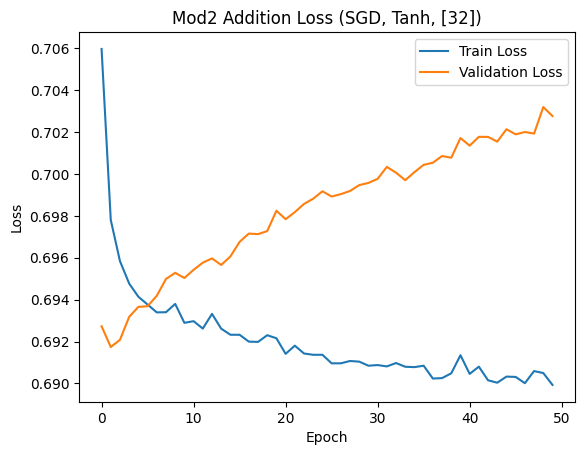

Result: Test Accuracy: 0.4336 | Training Duration: 0.27 sec

Running mod2 with Tanh, SGD, configuration: 2_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=SGD, Activation=Tanh, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 0.6956 | Train Acc: 0.4927 | Val Loss: 0.6951 | Val Acc: 0.5033
Epoch 2/50 | Train Loss: 0.6931 | Train Acc: 0.4976 | Val Loss: 0.6957 | Val Acc: 0.4771
Epoch 3/50 | Train Loss: 0.6924 | Train Acc: 0.5057 | Val Loss: 0.6968 | Val Acc: 0.4837
Epoch 4/50 | Train Loss: 0.6921 | Train Acc: 0.5220 | Val Loss: 0.6972 | Val Acc: 0.4902
Epoch 5/50 | Train Loss: 0.6919 | Train Acc: 0.5252 | Val Loss: 0.6974 | Val Acc: 0.4967
Epoch 6/50 | Train Loss: 0.6919 | Train Acc: 0.5268 | Val Loss: 0.6977 | Val Acc: 0.4967
Epoch 7/50 | Train Loss: 0.6916 | Train Acc: 0.5220 | Val Loss: 0.6979 | Val Acc: 0.4837
Epoch 8/50 | Train Loss: 0.6917 | Train Acc: 0.5301 | Val Loss: 0.6984 | Val Acc: 0.4967
Epoch 9/50 | Train Loss: 0.6917 | Train Acc: 0.5415 | Val Loss: 0.69

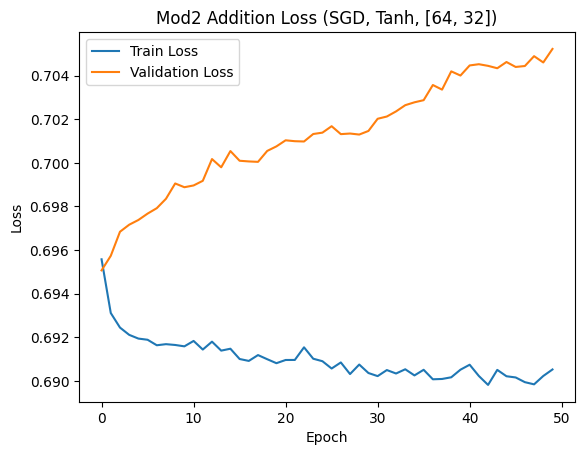

Result: Test Accuracy: 0.4297 | Training Duration: 0.31 sec

Running mod2 with Tanh, SGD, configuration: 3_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=SGD, Activation=Tanh, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 0.6947 | Train Acc: 0.4846 | Val Loss: 0.6906 | Val Acc: 0.5294
Epoch 2/50 | Train Loss: 0.6936 | Train Acc: 0.4862 | Val Loss: 0.6916 | Val Acc: 0.5425
Epoch 3/50 | Train Loss: 0.6934 | Train Acc: 0.4846 | Val Loss: 0.6925 | Val Acc: 0.5490
Epoch 4/50 | Train Loss: 0.6932 | Train Acc: 0.5024 | Val Loss: 0.6929 | Val Acc: 0.5425
Epoch 5/50 | Train Loss: 0.6930 | Train Acc: 0.5122 | Val Loss: 0.6934 | Val Acc: 0.5098
Epoch 6/50 | Train Loss: 0.6933 | Train Acc: 0.4992 | Val Loss: 0.6942 | Val Acc: 0.4902
Epoch 7/50 | Train Loss: 0.6930 | Train Acc: 0.5089 | Val Loss: 0.6937 | Val Acc: 0.5033
Epoch 8/50 | Train Loss: 0.6929 | Train Acc: 0.5041 | Val Loss: 0.6937 | Val Acc: 0.5033
Epoch 9/50 | Train Loss: 0.6926 | Train Acc: 0.5187 | Val Loss:

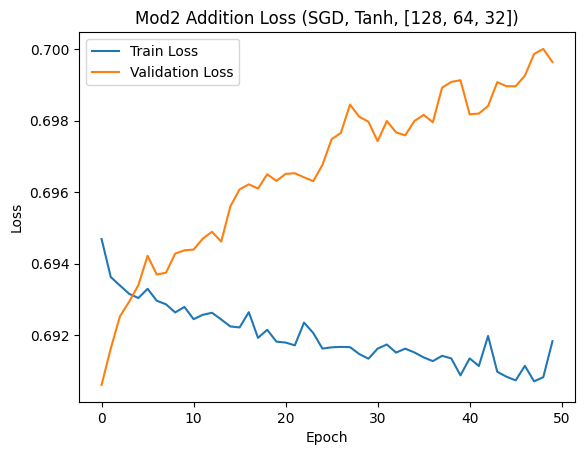

Result: Test Accuracy: 0.4258 | Training Duration: 0.30 sec

Running mod2 with Tanh, Adam, configuration: 1_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=Adam, Activation=Tanh, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 0.7015 | Train Acc: 0.4894 | Val Loss: 0.6993 | Val Acc: 0.4641
Epoch 2/50 | Train Loss: 0.6925 | Train Acc: 0.5138 | Val Loss: 0.7017 | Val Acc: 0.4183
Epoch 3/50 | Train Loss: 0.6911 | Train Acc: 0.5187 | Val Loss: 0.7073 | Val Acc: 0.4183
Epoch 4/50 | Train Loss: 0.6894 | Train Acc: 0.5268 | Val Loss: 0.7116 | Val Acc: 0.4052
Epoch 5/50 | Train Loss: 0.6894 | Train Acc: 0.5333 | Val Loss: 0.7181 | Val Acc: 0.4118
Epoch 6/50 | Train Loss: 0.6893 | Train Acc: 0.5447 | Val Loss: 0.7230 | Val Acc: 0.4052
Epoch 7/50 | Train Loss: 0.6884 | Train Acc: 0.5431 | Val Loss: 0.7237 | Val Acc: 0.3725
Epoch 8/50 | Train Loss: 0.6889 | Train Acc: 0.5512 | Val Loss: 0.7228 | Val Acc: 0.3725
Epoch 9/50 | Train Loss: 0.6887 | Train Acc: 0.5350 | Val Loss: 0.7237

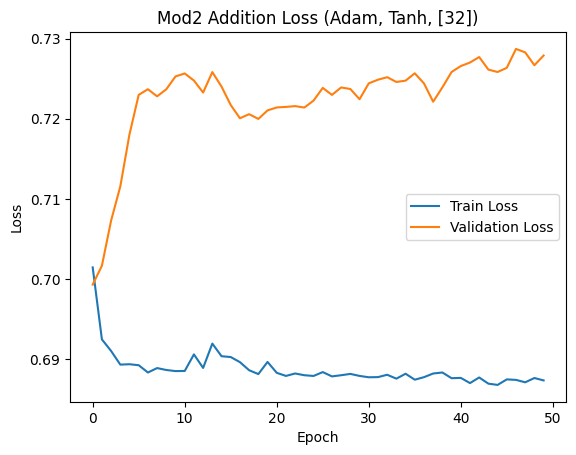

Result: Test Accuracy: 0.4727 | Training Duration: 0.32 sec

Running mod2 with Tanh, Adam, configuration: 2_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=Adam, Activation=Tanh, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 0.7063 | Train Acc: 0.4846 | Val Loss: 0.6986 | Val Acc: 0.5425
Epoch 2/50 | Train Loss: 0.6950 | Train Acc: 0.5171 | Val Loss: 0.7104 | Val Acc: 0.4641
Epoch 3/50 | Train Loss: 0.6927 | Train Acc: 0.5203 | Val Loss: 0.7013 | Val Acc: 0.4575
Epoch 4/50 | Train Loss: 0.6945 | Train Acc: 0.5268 | Val Loss: 0.7002 | Val Acc: 0.5098
Epoch 5/50 | Train Loss: 0.6916 | Train Acc: 0.5398 | Val Loss: 0.7068 | Val Acc: 0.4510
Epoch 6/50 | Train Loss: 0.6903 | Train Acc: 0.5203 | Val Loss: 0.7069 | Val Acc: 0.4248
Epoch 7/50 | Train Loss: 0.6910 | Train Acc: 0.5171 | Val Loss: 0.7039 | Val Acc: 0.4575
Epoch 8/50 | Train Loss: 0.6926 | Train Acc: 0.5041 | Val Loss: 0.6996 | Val Acc: 0.4510
Epoch 9/50 | Train Loss: 0.6905 | Train Acc: 0.5350 | Val Loss: 0.

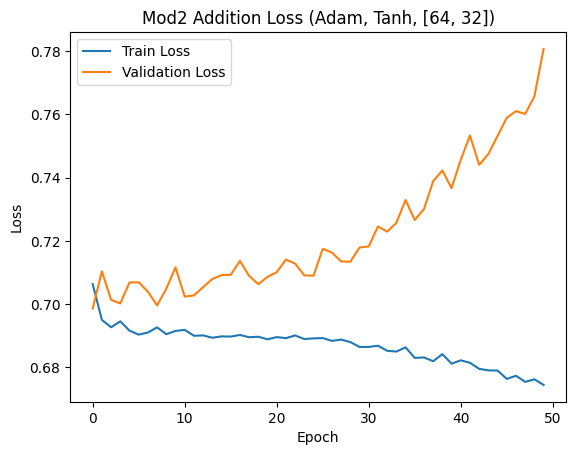

Result: Test Accuracy: 0.3828 | Training Duration: 0.32 sec

Running mod2 with Tanh, Adam, configuration: 3_hidden
=== Running Addition Modulo 2 Task ===
Parameters: Optimizer=Adam, Activation=Tanh, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 0.7118 | Train Acc: 0.4797 | Val Loss: 0.7131 | Val Acc: 0.4902
Epoch 2/50 | Train Loss: 0.7071 | Train Acc: 0.4667 | Val Loss: 0.6945 | Val Acc: 0.5098
Epoch 3/50 | Train Loss: 0.6920 | Train Acc: 0.5203 | Val Loss: 0.6977 | Val Acc: 0.4902
Epoch 4/50 | Train Loss: 0.6950 | Train Acc: 0.5073 | Val Loss: 0.6973 | Val Acc: 0.5229
Epoch 5/50 | Train Loss: 0.6919 | Train Acc: 0.5057 | Val Loss: 0.6972 | Val Acc: 0.4575
Epoch 6/50 | Train Loss: 0.6929 | Train Acc: 0.5187 | Val Loss: 0.6960 | Val Acc: 0.4444
Epoch 7/50 | Train Loss: 0.6928 | Train Acc: 0.5122 | Val Loss: 0.6961 | Val Acc: 0.4902
Epoch 8/50 | Train Loss: 0.6918 | Train Acc: 0.5089 | Val Loss: 0.6968 | Val Acc: 0.4837
Epoch 9/50 | Train Loss: 0.6929 | Train Acc: 0.5220 | Val Los

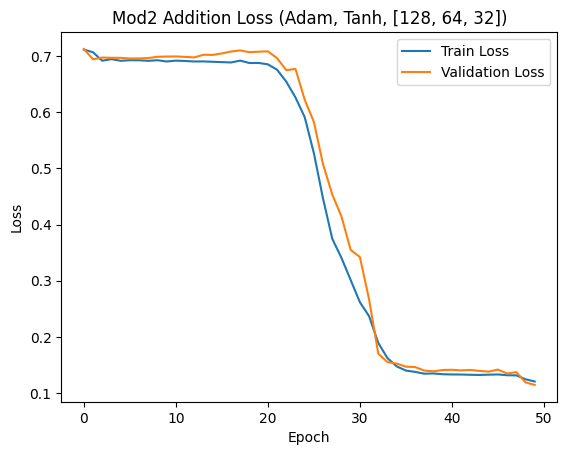

Result: Test Accuracy: 0.9570 | Training Duration: 0.34 sec



In [11]:
for act in activations:
    for opt in optimizers_list:
        for config_name, hidden_layers in hidden_layer_configs.items():
            print(f"Running mod2 with {act.__name__}, {opt}, configuration: {config_name}")
            _, test_acc, duration = main_mod2(act, opt, hidden_layers, num_epochs=num_epochs, batch_size=batch_size)
            print(f"Result: Test Accuracy: {test_acc:.4f} | Training Duration: {duration:.2f} sec\n")

SGD гірше збігається на даному наборі даних, аніж Adam (судячи з даних валідації). Тангенс гіперболічний дає кращі результати з оптимізатором Adam  на будь-якій кількості шарів перцепрону. Збільшення потужності моделі за допомогою додавання шарів підвищує якість за рахунок складності (але, очевидно це буде перенавчання, тож валідаційні метрики будуть рости лише до певного моменту). Найкраще справляється модель з 3 шарами, активаційною функцією ReLU та оптимізатором Adam.

### Digit Classification Task ###

Running digit classification with ReLU, SGD, configuration: 1_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=SGD, Activation=ReLU, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 2.1637 | Train Acc: 0.2586 | Val Loss: 2.0338 | Val Acc: 0.3829
Epoch 2/50 | Train Loss: 1.8918 | Train Acc: 0.5153 | Val Loss: 1.7574 | Val Acc: 0.5390
Epoch 3/50 | Train Loss: 1.6062 | Train Acc: 0.6469 | Val Loss: 1.4621 | Val Acc: 0.6766
Epoch 4/50 | Train Loss: 1.3179 | Train Acc: 0.7192 | Val Loss: 1.1880 | Val Acc: 0.7621
Epoch 5/50 | Train Loss: 1.0620 | Train Acc: 0.7683 | Val Loss: 0.9588 | Val Acc: 0.8141
Epoch 6/50 | Train Loss: 0.8515 | Train Acc: 0.8452 | Val Loss: 0.7786 | Val Acc: 0.8662
Epoch 7/50 | Train Loss: 0.6921 | Train Acc: 0.8758 | Val Loss: 0.6481 | Val Acc: 0.8699
Epoch 8/50 | Train Loss: 0.5732 | Train Acc: 0.9018 | Val Loss: 0.5523 | Val Acc: 0.8922
Epoch 9/50 | Train Loss: 0.4860 | Train Acc: 0.9147 | Val Loss: 0.4823 | Val Ac

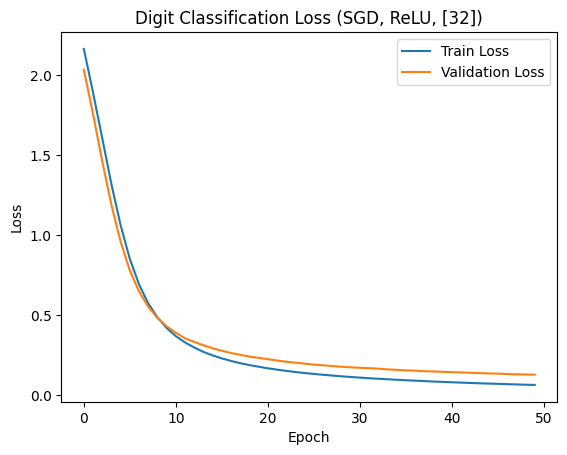

Result: Test Accuracy: 0.9688 | Training Duration: 0.36 sec

Running digit classification with ReLU, SGD, configuration: 2_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=SGD, Activation=ReLU, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 2.3133 | Train Acc: 0.1084 | Val Loss: 2.2922 | Val Acc: 0.1524
Epoch 2/50 | Train Loss: 2.2573 | Train Acc: 0.2308 | Val Loss: 2.2348 | Val Acc: 0.2788
Epoch 3/50 | Train Loss: 2.1878 | Train Acc: 0.3670 | Val Loss: 2.1533 | Val Acc: 0.3755
Epoch 4/50 | Train Loss: 2.0836 | Train Acc: 0.4347 | Val Loss: 2.0274 | Val Acc: 0.3941
Epoch 5/50 | Train Loss: 1.9252 | Train Acc: 0.4588 | Val Loss: 1.8474 | Val Acc: 0.5130
Epoch 6/50 | Train Loss: 1.7120 | Train Acc: 0.5542 | Val Loss: 1.6179 | Val Acc: 0.5948
Epoch 7/50 | Train Loss: 1.4670 | Train Acc: 0.6487 | Val Loss: 1.3694 | Val Acc: 0.6394
Epoch 8/50 | Train Loss: 1.2181 | Train Acc: 0.7164 | Val Loss: 1.1235 | Val Acc: 0.7100
Epoch 9/50 | Train Loss: 0.9860 | Train Acc: 0.77

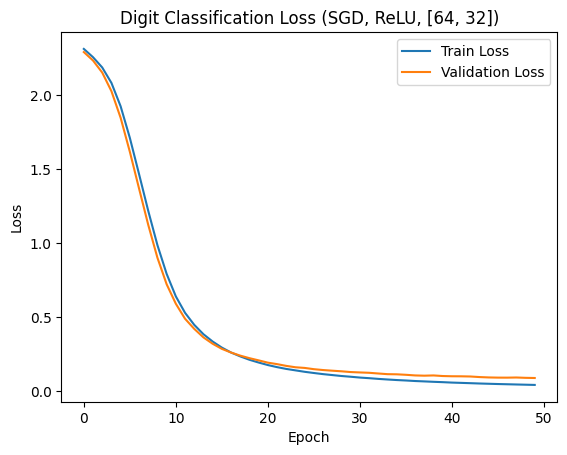

Result: Test Accuracy: 0.9555 | Training Duration: 0.38 sec

Running digit classification with ReLU, SGD, configuration: 3_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=SGD, Activation=ReLU, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 2.3033 | Train Acc: 0.1112 | Val Loss: 2.3053 | Val Acc: 0.1041
Epoch 2/50 | Train Loss: 2.2938 | Train Acc: 0.1529 | Val Loss: 2.2973 | Val Acc: 0.1264
Epoch 3/50 | Train Loss: 2.2842 | Train Acc: 0.1733 | Val Loss: 2.2874 | Val Acc: 0.1450
Epoch 4/50 | Train Loss: 2.2726 | Train Acc: 0.1956 | Val Loss: 2.2748 | Val Acc: 0.1710
Epoch 5/50 | Train Loss: 2.2576 | Train Acc: 0.2391 | Val Loss: 2.2579 | Val Acc: 0.2305
Epoch 6/50 | Train Loss: 2.2365 | Train Acc: 0.2892 | Val Loss: 2.2317 | Val Acc: 0.2565
Epoch 7/50 | Train Loss: 2.2045 | Train Acc: 0.2984 | Val Loss: 2.1930 | Val Acc: 0.2677
Epoch 8/50 | Train Loss: 2.1559 | Train Acc: 0.3068 | Val Loss: 2.1319 | Val Acc: 0.3048
Epoch 9/50 | Train Loss: 2.0789 | Train Acc:

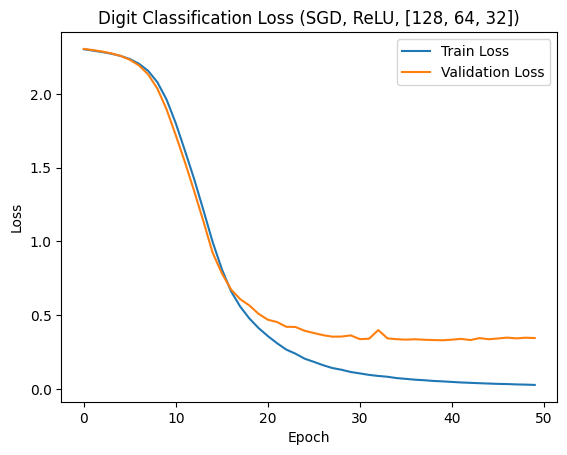

Result: Test Accuracy: 0.9777 | Training Duration: 0.41 sec

Running digit classification with ReLU, Adam, configuration: 1_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=Adam, Activation=ReLU, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 1.8470 | Train Acc: 0.4995 | Val Loss: 1.1948 | Val Acc: 0.7621
Epoch 2/50 | Train Loss: 0.7905 | Train Acc: 0.8452 | Val Loss: 0.4575 | Val Acc: 0.8885
Epoch 3/50 | Train Loss: 0.3298 | Train Acc: 0.9147 | Val Loss: 0.2527 | Val Acc: 0.9219
Epoch 4/50 | Train Loss: 0.1871 | Train Acc: 0.9444 | Val Loss: 0.1718 | Val Acc: 0.9442
Epoch 5/50 | Train Loss: 0.1242 | Train Acc: 0.9713 | Val Loss: 0.1200 | Val Acc: 0.9703
Epoch 6/50 | Train Loss: 0.0888 | Train Acc: 0.9796 | Val Loss: 0.1067 | Val Acc: 0.9703
Epoch 7/50 | Train Loss: 0.0666 | Train Acc: 0.9889 | Val Loss: 0.1027 | Val Acc: 0.9703
Epoch 8/50 | Train Loss: 0.0517 | Train Acc: 0.9926 | Val Loss: 0.0966 | Val Acc: 0.9703
Epoch 9/50 | Train Loss: 0.0407 | Train Acc: 0.9944

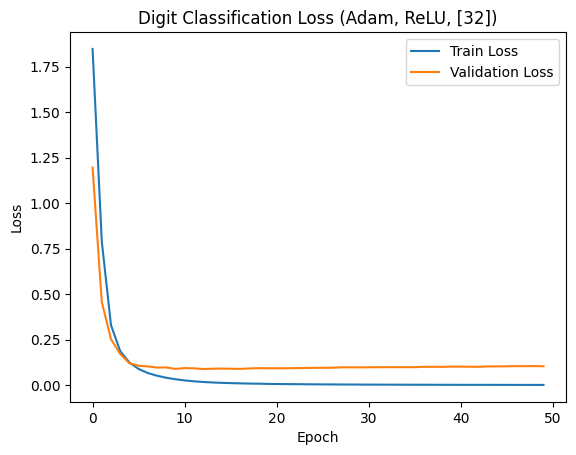

Result: Test Accuracy: 0.9710 | Training Duration: 0.45 sec

Running digit classification with ReLU, Adam, configuration: 2_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=Adam, Activation=ReLU, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 1.8300 | Train Acc: 0.4949 | Val Loss: 0.8689 | Val Acc: 0.7993
Epoch 2/50 | Train Loss: 0.4861 | Train Acc: 0.8814 | Val Loss: 0.2729 | Val Acc: 0.8885
Epoch 3/50 | Train Loss: 0.1624 | Train Acc: 0.9518 | Val Loss: 0.1516 | Val Acc: 0.9368
Epoch 4/50 | Train Loss: 0.0845 | Train Acc: 0.9759 | Val Loss: 0.1459 | Val Acc: 0.9591
Epoch 5/50 | Train Loss: 0.0414 | Train Acc: 0.9907 | Val Loss: 0.1337 | Val Acc: 0.9480
Epoch 6/50 | Train Loss: 0.0271 | Train Acc: 0.9917 | Val Loss: 0.1720 | Val Acc: 0.9628
Epoch 7/50 | Train Loss: 0.0171 | Train Acc: 0.9963 | Val Loss: 0.1494 | Val Acc: 0.9591
Epoch 8/50 | Train Loss: 0.0089 | Train Acc: 0.9991 | Val Loss: 0.1605 | Val Acc: 0.9554
Epoch 9/50 | Train Loss: 0.0067 | Train Acc: 0.

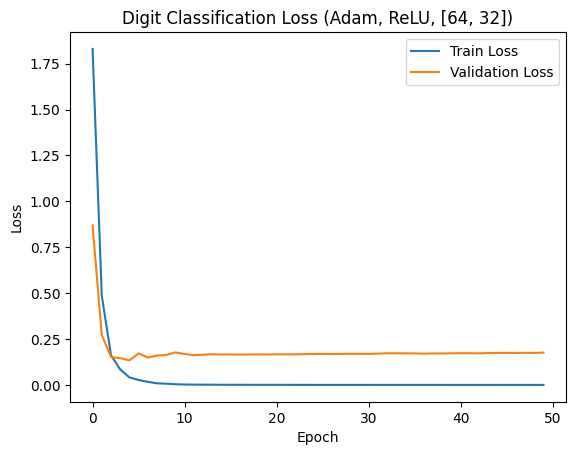

Result: Test Accuracy: 0.9800 | Training Duration: 0.53 sec

Running digit classification with ReLU, Adam, configuration: 3_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=Adam, Activation=ReLU, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 1.6938 | Train Acc: 0.5199 | Val Loss: 0.5898 | Val Acc: 0.8290
Epoch 2/50 | Train Loss: 0.3715 | Train Acc: 0.8860 | Val Loss: 0.2864 | Val Acc: 0.9108
Epoch 3/50 | Train Loss: 0.2020 | Train Acc: 0.9407 | Val Loss: 0.2289 | Val Acc: 0.9145
Epoch 4/50 | Train Loss: 0.0974 | Train Acc: 0.9666 | Val Loss: 0.1688 | Val Acc: 0.9554
Epoch 5/50 | Train Loss: 0.0563 | Train Acc: 0.9880 | Val Loss: 0.1227 | Val Acc: 0.9628
Epoch 6/50 | Train Loss: 0.0405 | Train Acc: 0.9842 | Val Loss: 0.0894 | Val Acc: 0.9665
Epoch 7/50 | Train Loss: 0.0200 | Train Acc: 0.9935 | Val Loss: 0.0953 | Val Acc: 0.9628
Epoch 8/50 | Train Loss: 0.0206 | Train Acc: 0.9944 | Val Loss: 0.1123 | Val Acc: 0.9591
Epoch 9/50 | Train Loss: 0.0095 | Train Ac

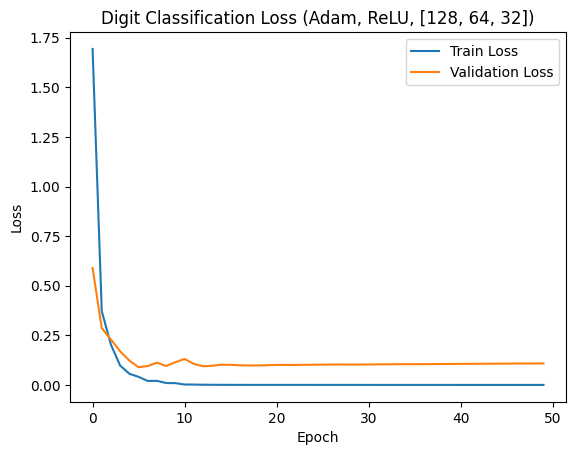

Result: Test Accuracy: 0.9777 | Training Duration: 0.60 sec

Running digit classification with Tanh, SGD, configuration: 1_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=SGD, Activation=Tanh, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 2.1404 | Train Acc: 0.2882 | Val Loss: 1.8754 | Val Acc: 0.5539
Epoch 2/50 | Train Loss: 1.6902 | Train Acc: 0.6274 | Val Loss: 1.4994 | Val Acc: 0.7509
Epoch 3/50 | Train Loss: 1.3501 | Train Acc: 0.7822 | Val Loss: 1.2111 | Val Acc: 0.8290
Epoch 4/50 | Train Loss: 1.0946 | Train Acc: 0.8499 | Val Loss: 0.9920 | Val Acc: 0.8773
Epoch 5/50 | Train Loss: 0.9018 | Train Acc: 0.8842 | Val Loss: 0.8275 | Val Acc: 0.8959
Epoch 6/50 | Train Loss: 0.7588 | Train Acc: 0.9027 | Val Loss: 0.7042 | Val Acc: 0.9108
Epoch 7/50 | Train Loss: 0.6510 | Train Acc: 0.9073 | Val Loss: 0.6136 | Val Acc: 0.9182
Epoch 8/50 | Train Loss: 0.5683 | Train Acc: 0.9212 | Val Loss: 0.5431 | Val Acc: 0.9182
Epoch 9/50 | Train Loss: 0.5035 | Train Acc: 0.9268 |

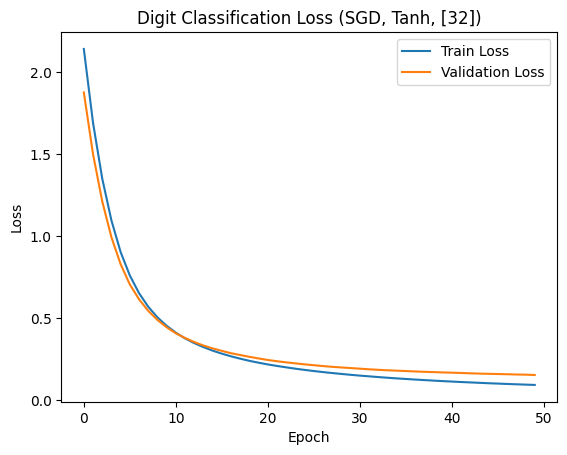

Result: Test Accuracy: 0.9710 | Training Duration: 0.43 sec

Running digit classification with Tanh, SGD, configuration: 2_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=SGD, Activation=Tanh, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 2.2295 | Train Acc: 0.2271 | Val Loss: 2.0530 | Val Acc: 0.5204
Epoch 2/50 | Train Loss: 1.9580 | Train Acc: 0.5681 | Val Loss: 1.7661 | Val Acc: 0.7212
Epoch 3/50 | Train Loss: 1.6772 | Train Acc: 0.7081 | Val Loss: 1.4859 | Val Acc: 0.7807
Epoch 4/50 | Train Loss: 1.4162 | Train Acc: 0.7618 | Val Loss: 1.2374 | Val Acc: 0.8253
Epoch 5/50 | Train Loss: 1.1918 | Train Acc: 0.7859 | Val Loss: 1.0367 | Val Acc: 0.8550
Epoch 6/50 | Train Loss: 1.0125 | Train Acc: 0.8276 | Val Loss: 0.8785 | Val Acc: 0.8699
Epoch 7/50 | Train Loss: 0.8706 | Train Acc: 0.8536 | Val Loss: 0.7552 | Val Acc: 0.8959
Epoch 8/50 | Train Loss: 0.7580 | Train Acc: 0.8656 | Val Loss: 0.6566 | Val Acc: 0.8996
Epoch 9/50 | Train Loss: 0.6678 | Train Acc: 0.88

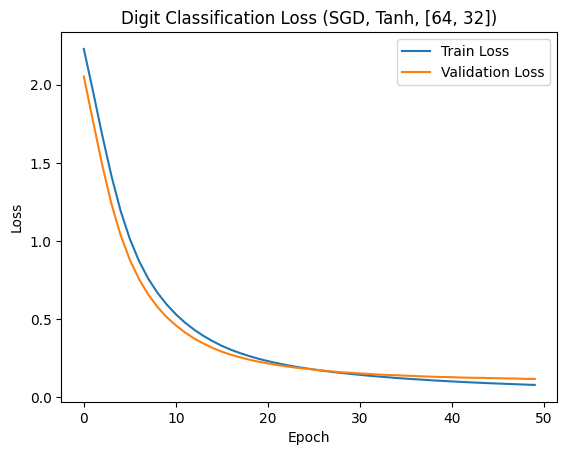

Result: Test Accuracy: 0.9644 | Training Duration: 0.48 sec

Running digit classification with Tanh, SGD, configuration: 3_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=SGD, Activation=Tanh, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 2.2618 | Train Acc: 0.2234 | Val Loss: 2.1851 | Val Acc: 0.3271
Epoch 2/50 | Train Loss: 2.1011 | Train Acc: 0.3939 | Val Loss: 2.0096 | Val Acc: 0.4201
Epoch 3/50 | Train Loss: 1.8971 | Train Acc: 0.5171 | Val Loss: 1.7938 | Val Acc: 0.5130
Epoch 4/50 | Train Loss: 1.6634 | Train Acc: 0.6209 | Val Loss: 1.5634 | Val Acc: 0.6171
Epoch 5/50 | Train Loss: 1.4289 | Train Acc: 0.6997 | Val Loss: 1.3397 | Val Acc: 0.7807
Epoch 6/50 | Train Loss: 1.2125 | Train Acc: 0.7748 | Val Loss: 1.1392 | Val Acc: 0.8253
Epoch 7/50 | Train Loss: 1.0210 | Train Acc: 0.8313 | Val Loss: 0.9656 | Val Acc: 0.8476
Epoch 8/50 | Train Loss: 0.8586 | Train Acc: 0.8619 | Val Loss: 0.8214 | Val Acc: 0.8587
Epoch 9/50 | Train Loss: 0.7281 | Train Acc:

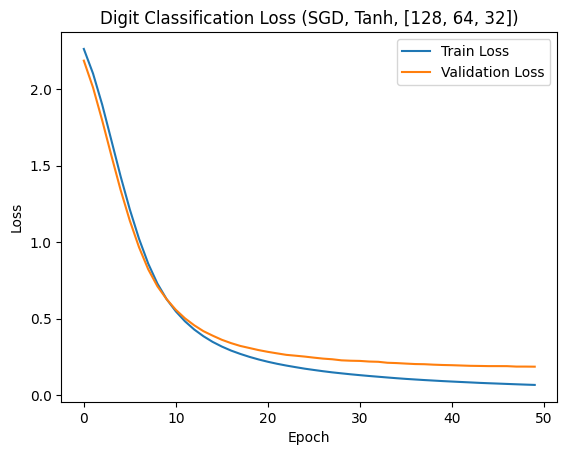

Result: Test Accuracy: 0.9465 | Training Duration: 0.52 sec

Running digit classification with Tanh, Adam, configuration: 1_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=Adam, Activation=Tanh, Hidden Layers=[32]
Epoch 1/50 | Train Loss: 1.7059 | Train Acc: 0.6108 | Val Loss: 0.9655 | Val Acc: 0.8773
Epoch 2/50 | Train Loss: 0.7121 | Train Acc: 0.8851 | Val Loss: 0.4214 | Val Acc: 0.9257
Epoch 3/50 | Train Loss: 0.3398 | Train Acc: 0.9407 | Val Loss: 0.2389 | Val Acc: 0.9554
Epoch 4/50 | Train Loss: 0.1987 | Train Acc: 0.9629 | Val Loss: 0.1675 | Val Acc: 0.9665
Epoch 5/50 | Train Loss: 0.1372 | Train Acc: 0.9750 | Val Loss: 0.1350 | Val Acc: 0.9740
Epoch 6/50 | Train Loss: 0.1023 | Train Acc: 0.9842 | Val Loss: 0.1214 | Val Acc: 0.9777
Epoch 7/50 | Train Loss: 0.0807 | Train Acc: 0.9889 | Val Loss: 0.1110 | Val Acc: 0.9703
Epoch 8/50 | Train Loss: 0.0655 | Train Acc: 0.9926 | Val Loss: 0.1031 | Val Acc: 0.9740
Epoch 9/50 | Train Loss: 0.0528 | Train Acc: 0.9954

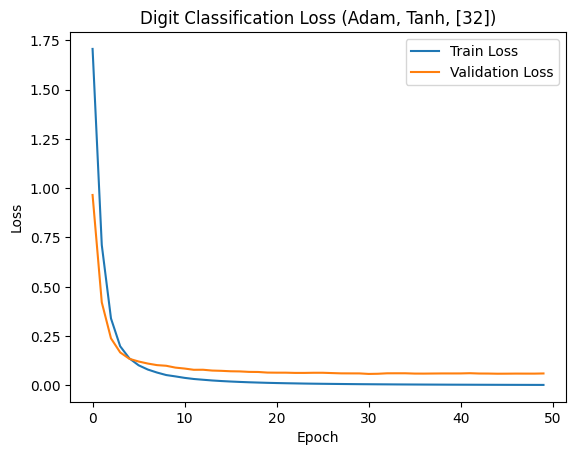

Result: Test Accuracy: 0.9688 | Training Duration: 0.51 sec

Running digit classification with Tanh, Adam, configuration: 2_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=Adam, Activation=Tanh, Hidden Layers=[64, 32]
Epoch 1/50 | Train Loss: 1.5447 | Train Acc: 0.6719 | Val Loss: 0.7878 | Val Acc: 0.8439
Epoch 2/50 | Train Loss: 0.5331 | Train Acc: 0.9018 | Val Loss: 0.3383 | Val Acc: 0.9145
Epoch 3/50 | Train Loss: 0.2277 | Train Acc: 0.9527 | Val Loss: 0.2081 | Val Acc: 0.9294
Epoch 4/50 | Train Loss: 0.1193 | Train Acc: 0.9778 | Val Loss: 0.1477 | Val Acc: 0.9368
Epoch 5/50 | Train Loss: 0.0665 | Train Acc: 0.9870 | Val Loss: 0.1335 | Val Acc: 0.9517
Epoch 6/50 | Train Loss: 0.0433 | Train Acc: 0.9944 | Val Loss: 0.1084 | Val Acc: 0.9554
Epoch 7/50 | Train Loss: 0.0299 | Train Acc: 0.9972 | Val Loss: 0.1011 | Val Acc: 0.9628
Epoch 8/50 | Train Loss: 0.0213 | Train Acc: 0.9972 | Val Loss: 0.0986 | Val Acc: 0.9665
Epoch 9/50 | Train Loss: 0.0165 | Train Acc: 0.

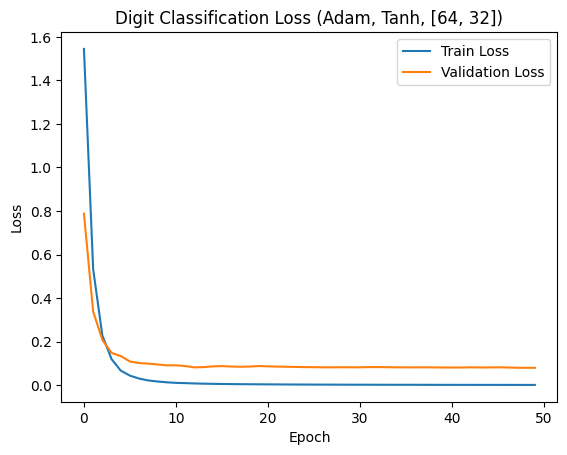

Result: Test Accuracy: 0.9644 | Training Duration: 0.55 sec

Running digit classification with Tanh, Adam, configuration: 3_hidden
=== Running Digit Classification Task ===
Parameters: Optimizer=Adam, Activation=Tanh, Hidden Layers=[128, 64, 32]
Epoch 1/50 | Train Loss: 1.3937 | Train Acc: 0.7118 | Val Loss: 0.6300 | Val Acc: 0.8699
Epoch 2/50 | Train Loss: 0.3817 | Train Acc: 0.9314 | Val Loss: 0.2899 | Val Acc: 0.9182
Epoch 3/50 | Train Loss: 0.1465 | Train Acc: 0.9741 | Val Loss: 0.1762 | Val Acc: 0.9405
Epoch 4/50 | Train Loss: 0.0587 | Train Acc: 0.9880 | Val Loss: 0.1357 | Val Acc: 0.9554
Epoch 5/50 | Train Loss: 0.0295 | Train Acc: 0.9954 | Val Loss: 0.1045 | Val Acc: 0.9703
Epoch 6/50 | Train Loss: 0.0226 | Train Acc: 0.9972 | Val Loss: 0.1281 | Val Acc: 0.9665
Epoch 7/50 | Train Loss: 0.0215 | Train Acc: 0.9981 | Val Loss: 0.1407 | Val Acc: 0.9517
Epoch 8/50 | Train Loss: 0.0270 | Train Acc: 0.9972 | Val Loss: 0.1146 | Val Acc: 0.9628
Epoch 9/50 | Train Loss: 0.0088 | Train Ac

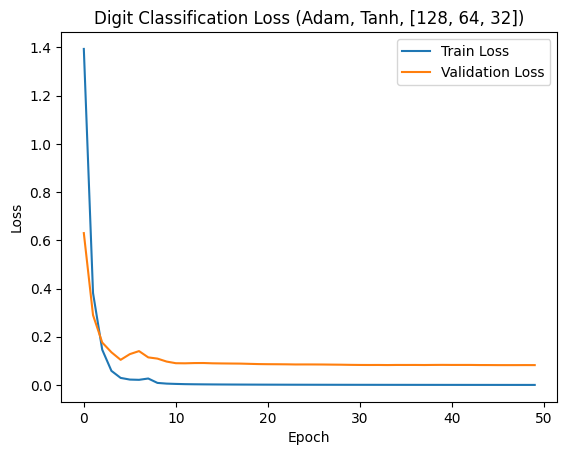

Result: Test Accuracy: 0.9555 | Training Duration: 0.57 sec



In [12]:
print("### Digit Classification Task ###\n")
for act in activations:
    for opt in optimizers_list:
        for config_name, hidden_layers in hidden_layer_configs.items():
            print(f"Running digit classification with {act.__name__}, {opt}, configuration: {config_name}")
            _, test_acc, duration = main_digits(act, opt, hidden_layers, num_epochs=num_epochs, batch_size=batch_size)
            print(f"Result: Test Accuracy: {test_acc:.4f} | Training Duration: {duration:.2f} sec\n")

SGD схожим чином збігається на даному наборі даних Adam (судячи з даних валідації). Тангенс гіперболічний дає кращі результати з оптимізатором Adam. Збільшення потужності моделі за допомогою додавання шарів знижує метрики на валіції через перенавчання. Найкраще справляється модель з 1 шаром, активаційною функцією Tanh та оптимізатором Adam.